In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import pandas as pd
import seaborn as sns
sns.set_context='talk'

# Objective

We want to compare SNR between different filters and workflows. To do this we will create example chromatograms with a pure signal then add noise to that signal. We will run the filtering on the signal+noise and compare the difference between the filtered signal and the true signal. 

The most straightforward way would be to create gaussian functions for the peaks and add a random noise to that. We may also want to consider adding flicker or pink_noise in addition to random noise. 

Below are the two functions we will use, generate peak and generate signal. 


In [2]:
def generate_peak(center:float, fwhm:float, amplitude:float):
    """
    Generate a gaussian signal and return the function
    
    f(x) = amplitude * exp -(x-center)^2/(2*var^2)
    
    fwhm = 2.3548*var
    amplitude = max signal of the peak
    
    https://mathworld.wolfram.com/GaussianFunction.html
    
    :param center: location of the peak mean or center
    :param fwhm: the width of the peak as measured by full width half maximum
    :amplitude: the height or amplitude of the peak
    :return peak_function: the gaussian function for the specified peak
    """
    
    var = fwhm/2.3548
    peak_function =  lambda X: [amplitude * np.exp(-(x-center)**2/(2*var**2)) for x in X]
    return peak_function
    
    
def generate_signal(*peak_funcs, start=0, stop=100, sampling=1000):
    """
    Generates an example chromatogram from peak functions returned by the 'generate_peak' function. 
    User may specify start and stop parameters as well as an estimate for sampling. 
    
    Note, sampling may not be exact if there are not an integer number of samples possible between stop and start indices. 
    :param peak_funcs: peak_function giving the equation for each peak to be plotted
    :param start: start time or position for the signal
    :param stop: stop time or position for the signal
    :param sampling: the sampling frequency
    :return (X,Y): returns the time/position and signal arrays

    """
    X = np.linspace(start,stop, np.ceil((stop-start)*sampling).astype(np.int))
    Y = np.zeros(X.shape)
    for pk in peak_funcs:
        Y += pk(X)
    return X, Y

Plot the pure signal to verify that we have 2 peaks with centers at 4 and 8 with amplitude of 2 and 1 and widths of 0.2 and 0.5 respectively. 

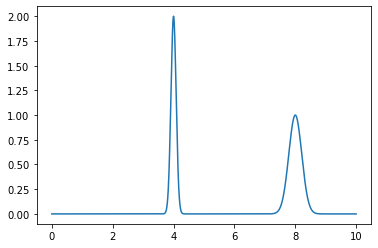

In [3]:
p1 = generate_peak(4,0.2,2)
p2 = generate_peak(8,0.5,1)
tr, sig = generate_signal(p1,p2, stop=10, sampling=10000)
plt.plot(tr,sig)

Create an array that will be just noise (we may expand this later to include flicker noise). Add the noise to the signal and plot the result

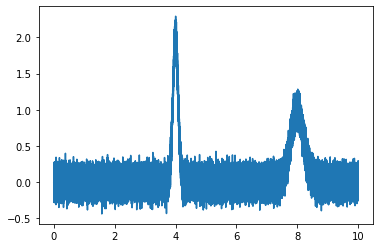

In [4]:
noise = np.random.normal(0,0.1, sig.shape)
plt.plot(tr, sig+noise)

For our first filtering algorithm lets implment a butterworth filter (mostly following the example given in the scipy.signal.butter documentation). 

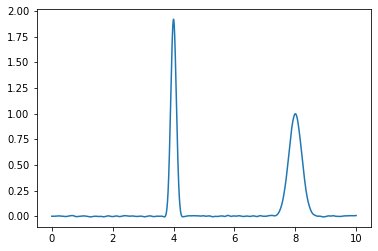

In [5]:
def filter_butter(Y, X, cutoff: float, order: int):
    """
    Butterworth digital filter, applies the filter forwards and backwards so the end result
    won't have a phase shift. Order will be multiplied by 2 (once for each pass of the filter).

    :param separation: Separation to filter
    :param cutoff: Digital filter frequency cutoff
    :param order: Order for the single pass of the filter
    :return: filtered RFu
    """

    # Filtering Functions
    # noinspection PyTupleAssignmentBalance
    def butter_lowpass():
        nyq = 0.5 * dt
        normal_cutoff = cutoff / nyq
        b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    dt = 1 / np.median(np.diff(X))
    b, a = butter_lowpass()

    rfu_filtered = signal.filtfilt(b, a, Y, padlen=24, padtype='constant')
    return rfu_filtered


sig_butter = filter_butter(sig+noise, tr, 5, 2)
plt.plot(tr, sig_butter)
pass

Adding a butterworth filter reduces the random noise immensly. One important thing to note is to set appropriate cutoff frequencies and filter orders. If you set the cutoff frequency too low, your signal will begin to be filtered out as well as the noise. Below is a plot of filtered signals at different cutoff frequencies. At the lowest frequencies there is a substantial loss in signal. The lower plot is the difference between the filtered signal and the pure signal. 

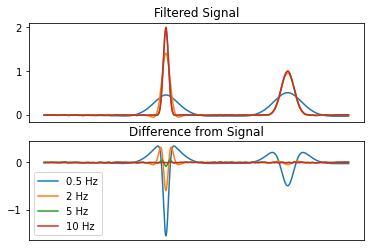

In [6]:
# Compare the effect of cutoff frequency
fig, axes = plt.subplots(2,1)
for cutoff in [0.5,2,5,10]:
    filt = filter_butter(sig+noise, tr, cutoff, 2)
    axes[0].plot(filt,  label=f'{cutoff} Hz')
    axes[1].plot(filt - sig,  label=f'{cutoff} Hz')
axes[0].set_xticks([])
axes[1].set_xticks([])
axes[0].set_title('Filtered Signal')

axes[1].set_title('Difference from Signal')
plt.legend()
pass

Next we will write some code for our oversampling filter. The idea behind the oversample filter is similar to taking an average. Within our sampling period, we will sample the signal hundreds to thousands of times. We will then take those points and average them together. The random noise will be largely averaged out and you will be left with a more accurate measurement of the signal. Practically we can only sample as high as our ADC is capable, and so oversampling will have the greatest effect when we need to measure low frequency signals and have an ADC with a high sampling frequency. This is ideal for chromatography and capillary electrophoresis as they are typically sampled at 4 Hz and many affordable ADC's have sampling frequency between $10^4$ and $10^6$ Hz. 

An additional note, the architecture of your ADC is also important to consider. A SAR ADC only needs a few microseconds to measure the incoming signal, and the rest of the time the SAR ADC is idle when sampling at low frequencies. However the $\Delta\Sigma$ ADC already incorporates oversampling by essentially averaging together how many times the voltage is above or below a refrence voltages hundreds of thousands of times a second. The measurement from a $\Delta\Sigma$ ADC becomes more accurate the the more times the signal is sampled. It would be more beneficial to let the $\Delta\Sigma$ ADC measure for the longest time possible rather than try and introduce an oversampling filter. 

https://en.wikipedia.org/wiki/Delta-sigma_modulation

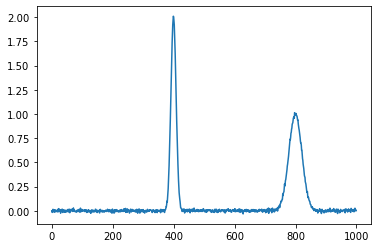

In [7]:
def filter_oversampled(Y, reducing_factor=10, method='mean', include_extra=True):
    """
    Returns a filtered array that has been reduced from sampling_freq to output_freq 
    points are combined according to the method
    
    :param Y: 1D array 
    :param reducing_factor: how many samples to average together
    :param method: str, 'mean' or 'median', reduce points to either the mean or median function
    :param include_extra: bool, when  True, if there is a modulus when Y is divided by the reducing factor
                          those remaining points will be averaged together and added onto the array
    :return Y_reduced: reduced array
    """
    methods = {'mean':np.mean, 'median':np.median}
    
    rf = reducing_factor
    s2 = [ methods[method](Y[idx*rf:(idx+1)*rf]) for idx in range(np.floor(Y.shape[0]/rf).astype(np.int))]
    
    if sig.shape[0]%rf>0 and include_extra:
        s2.append(methods[method](Y[(idx+1)*rf:]))
    return s2

sig_over = filter_oversampled(sig+noise, reducing_factor=100)
plt.plot(sig_over)

In addition to our oversampling method, scipy has a decimate function that first filters the data points using a low pass filter before downsampling. Similar to our method above we specify a downsampling or reducing factor (q). Additionally we have the option to pass in filter order and a filter type (infinite impulse response (iir) or finite impulse response (fir)). Lets use the same reducing factor as above and include a 2nd order iir filter. 

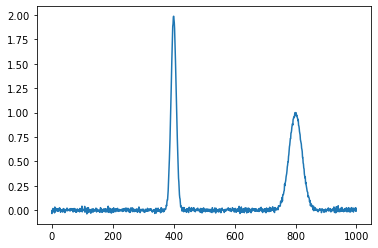

In [8]:
dc = signal.decimate(sig+noise, q=100, n=2, ftype='iir')
plt.plot(dc)

We have our filtering functions ready to be used lets create a function that will calculate some common performance metrics. 

In [9]:
def get_performance_specs(filt_sig, sig, noise_region=(100,200), adc_range=10, results=False):
    '''
    Return some common peak and chromatogram performance metrics. 
    :param filt_sig: 1D array containing the filtered signal
    :param sig: 1D array containing the pure signal
    :param noise_region: tuple containing the start and stop indices for the region to calculate noise. 
    :adc_range: the ADC's range for a given measurement, used to calculate bit_resolution
    :param results: bool, When True, print the results for inspection
    :return data: pd.DataFrame containing the performance metrics for this separation

    
    metrics:
    noise- standard deviation across the specified noise_region
    background- the average value across the noise region
    signal- the maximum signal value detected after background subtraction
    snr- signal to noise ratio, where signal is divided by the noise
    sigma_3- this value represents the limit of detection at 3*noise.
    bit_resolution- what is the most significant bit of data if you had to divide the ADC range by the noise
    avg_residual- what is the average absolute difference between the filtered signal and the pure signal
    noise_residual- what is the average absolute difference between the fitlered signal and the pure signal in the noise region
    
    '''
    data = {}
    

    data['noise'] = np.std(filt_sig[noise_region[0]:noise_region[1]])
    data['background'] = np.mean(filt_sig[noise_region[0]:noise_region[1]])
    data['signal'] = max(filt_sig)-data['background']
    data['snr'] = data['signal']/data['noise']
    data['sigma_3'] = data['noise']*3
    data['bit_resolution'] = np.log2(adc_range/data['noise'])
    data['avg_residual'] = np.mean(np.abs(filt_sig-sig)) 
    data['noise_residual'] = np.mean(np.abs(filt_sig[noise_region[0]:noise_region[1]]-
                                           sig[noise_region[0]:noise_region[1]]))
    
    if results:
        for key, value in data.items():
            print(f"{key}: {value:.3e}")
    return pd.DataFrame(data, index=[0])


# One thing to note, is that length of our decimated/downsampled signal and pure signal will need to match.
# To do this we will generate the pure signal again at the reduced sampling rate

_, dc_signal = generate_signal(p1,p2, stop=10, sampling=10000/100)
get_performance_specs(dc, dc_signal, noise_region =(0,2*200))

,noise,background,signal,snr,sigma_3,bit_resolution,avg_residual,noise_residual
0,0.257794,0.049178,1.93726,7.514768,0.773381,5.277639,0.012495,0.012071


Now lets test several conditions using a signal/trace that is much more practical. The effective number of bits (ENOB) for a 16 bit ADC is often 1-2 bit lower. Lets assume we have a ADC with an ENOB of 14. We will use this to calculate our noise by dividing the ADC range by the ENOB. For our peaks we will use two peaks, one at the 3 sigma detection limit and the other a factor of 10 below the 3 sigma detection limit.

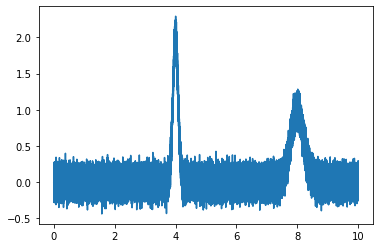

In [10]:
# Now lets get some metrics

# Set up our separation with noise around 14 bit limit
noise_amplitude = 10/2**14

# put in a few peaks
p1 = generate_peak(4,0.5,3*noise_amplitude) # This peak will be just above the baseline
p2 = generate_peak(6,0.5,0.3*noise_amplitude) # This peak will be below the noise floor by a factor of 10

# Generate the signal
low_tr, low_sig = generate_signal(p1,p2, stop=100, sampling=100)
low_noise = np.random.normal(0,noise_amplitude, low_sig.shape)
plt.plot(tr,sig+noise)

As we can see by the plot, we have one peak that is just above the baseline for our raw data. One other thing to note about the data is that we are including a large portion of the data for our noise measurement (everything after 10 s). This will help reduce any bias between sample sizes as we decimate from high sampling rates to low sampling rates. 

We will look at a few different cases as described in the code below, changing the sampling rates, and combination or selection of filters and oversampling filters. In each case we will calculate the performance metrics and append that to a dataframe containing the metrics of all of our tests. 

In [11]:
# low frequency butterworth filter
low_sig_butter = filter_butter(low_sig+low_noise, low_tr, 5, 2)
metrics  = get_performance_specs(low_sig_butter, low_sig, noise_region=[1000,9000])
metrics['label']='Butter Low Frequency'

# Raw low frequency
mc  = get_performance_specs(low_sig+low_noise, low_sig, noise_region=[1000,9000])
mc['label']='Raw Low Frequency'
metrics= metrics.append(mc, ignore_index=True)

# Generate the high sampling frequency signals
tr, sig = generate_signal(p1,p2, stop=100, sampling=10000)
noise = np.random.normal(0,noise_amplitude, sig.shape)

# high frequency butterworth filter
sig_butter = filter_butter(sig+noise, tr, 5, 2)
mc  = get_performance_specs(sig_butter, sig, noise_region=[100000,900000])
mc['label']='Butter High Frequency'
metrics= metrics.append(mc, ignore_index=True)

# Raw High frequency
mc  = get_performance_specs(sig+noise, sig, noise_region=[1000,9000])
mc['label']='Raw High Frequency'
metrics= metrics.append(mc, ignore_index=True)

# Decimation Oversampling Filter
noisy = sig + noise
dc_tr, dc_signal = generate_signal(p1, p2, start=0,stop=100,sampling=100)
dc = signal.decimate(noisy, 100, 2, 'iir')
mc = get_performance_specs(dc,dc_signal, noise_region=[1000,9000])
mc['label']='Decimation'
metrics= metrics.append(mc, ignore_index=True)

# Decimation Oversampling + Butterworth Filter
dc_tr, dc_signal =  generate_signal(p1, p2, start=0,stop=100,sampling=100)
dc_filt = filter_butter(dc, dc_tr, cutoff=5, order=2)
mc = get_performance_specs(dc_filt,dc_signal, noise_region=[1000,9000])
mc['label']='Decimation+Butter'
metrics = metrics.append(mc, ignore_index=True)

# Oversampled Mean Filter
os_avg = filter_oversampled(noisy, 100)
mc = get_performance_specs(os_avg,dc_signal, noise_region=[1000,9000])
mc['label']='Oversample Mean'
metrics = metrics.append(mc, ignore_index=True)

# Oversampled Mean Filter + Butterworth Filter
os_filt_avg = filter_butter(os_avg, dc_tr, cutoff=5, order=2)
mc = get_performance_specs(os_filt_avg,dc_signal, noise_region=[1000,9000])
mc['label']='Oversample Mean+Butter'
metrics = metrics.append(mc, ignore_index=True)
metrics

,noise,background,signal,snr,sigma_3,bit_resolution,avg_residual,noise_residual,label
0,0.000179,-7.457200e-06,0.001895,10.616612,0.000536,15.773685,0.000144,0.000143,Butter Low Frequency
1,0.000598,-7.276554e-06,0.003223,5.387221,0.001795,14.028950,0.000481,0.000479,Raw Low Frequency
2,0.000018,-4.272295e-07,0.001846,104.691857,0.000053,19.113227,0.000014,0.000014,Butter High Frequency
3,0.000601,-6.820989e-06,0.004449,7.406363,0.001802,14.022996,0.000487,0.000480,Raw High Frequency
4,0.000075,6.757713e-08,0.001956,25.979168,0.000226,17.018924,0.000060,0.000060,Decimation
5,0.000019,6.160299e-08,0.001805,93.744880,0.000058,18.986781,0.000016,0.000015,Decimation+Butter
6,0.000061,-4.298385e-07,0.001945,31.800727,0.000184,17.318711,0.000049,0.000049,Oversample Mean
7,0.000018,-4.294249e-07,0.001845,104.859850,0.000053,19.116344,0.000014,0.000014,Oversample Mean+Butter


Lets quickly inspect the SNR below using a barplot and seaborn. 

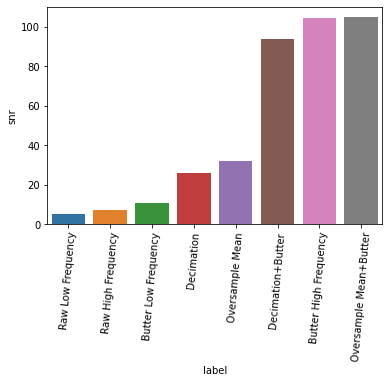

In [12]:
fig, ax= plt.subplots()
sns.barplot(y='snr', x='label', data=metrics.sort_values('snr'), ax=ax)
plt.xticks(rotation=85)
pass

A few things stick out:
1. when higher sampling frequencies are used there is a substantial improvement in SNR after filtering.
1. there is only a slight difference between Decimation and Oversample Mean, but the oversample mean had a greater SNR
1. similarily there is a sligh increase in snr when oversampling + butterworth filter is used rather than the butterworth filter alone. 

The last point is pretty important. If we start sampling every signal at 500kHz, we will start filling up our harddrive fairly quickly with our chromatograms (especially if we are recording multiple parameters at the same time, ie, time, signal, voltage, current, pressure, etc...). But, with the oversampled data, the final data is downsampled to a low frequency (often <10 Hz). Thousands of these data files could fit into a single file measured at 500kHz. And what is better, we actually **gain** SNR when moving to a downsampled dataset. Best of both worlds! 

Now lets plot the difference between some of the filtered data. 

Text(0.5, 0, 'Time (s)')

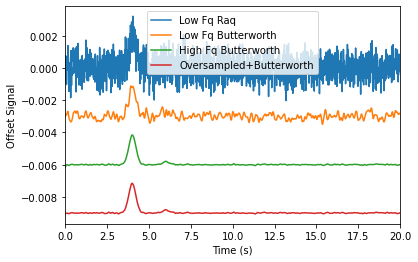

In [13]:
fig, ax = plt.subplots()
ax.plot(low_tr, low_sig+low_noise, label='Low Fq Raq')
ax.plot(low_tr, low_sig_butter-0.003, label='Low Fq Butterworth')
ax.plot(tr, sig_butter-0.006, label='High Fq Butterworth' )
ax.plot(dc_tr, os_filt_avg-0.009, label='Oversampled+Butterworth')

plt.legend()
ax.set_xlim((0,20))
ax.set_ylabel('Offset Signal')
ax.set_xlabel('Time (s)')

You can see in the above graph how much of a difference that extra SNR makes in detecting low abundance peaks. Our peak that was just at the LOD is now easily distinguishable at 20x that of the raw signal. Importantly, our peak (tr=6 s) that was previously hidden inside the noise of the low frequency butter filter data is visible in the oversampled data and able to be integrated and analyzed. What is great about this, is this is essentially 'free' signal given that many ADC's used in the lab are SAR ADC's with $10^5$ Hz maximum sampling frequency. A little code can improve the SNR by 10x compared to sampling at or near the final sampling frequency.

Now to make an animated plot that goes from our Low fq raw data to our final data

In [14]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
%matplotlib qt
def transition(x, y_start, y_final, frame_num, end_frame=10, start_frame=5):
    """
    Lets use a data generator so we don't have to worry about advancing frames. 
    We will simply interpolate data values between y_start and y_final using a
    line. Add in end_frame and start_frame for the animation to pause at the
    start and stop. 
    
    :param x: 1D array for the x-axis
    :param y_start: 1D array, starting signal
    :param y_final: 1D array, final signal
    :param frame_num: the number of frames to generate
    :param end_Frame: the number of frames dedicated to show the final state
    :param start_frame: the number of frames dedicated to show the start state
    :yield (x, y_i): yields the x dimension and transitioning y_dimension
    """
    y_diff = (y_final-y_start)/(frame_num-end_frame-start_frame)
    for frame in range(frame_num):
        if frame < start_frame:
            yield x, y_start
        elif frame < frame_num-end_frame:
            yield x, y_diff*(frame-start_frame)+y_start
        else:
            yield x, y_final
    
def init():
    """Some small items to adjust our plot"""
    ax.set_xlim(0,20)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Signal (V)')
    ax.set_title("Oversample Filter")
    plt.tight_layout()
    return line, 
    
def update(data):
    """
    Update the plot following FunAnimation request returns the artist object
    """
    line.set_data(data)
    return line, 

fig, ax = plt.subplots()
line, = ax.plot(dc_tr,low_sig+low_noise, lw=2, color='r')

data_gen = transition(dc_tr, low_sig+low_noise, os_filt_avg,100, end_frame=20, start_frame=20)
data_animation = animation.FuncAnimation(fig, update, data_gen, init_func=init, blit=True, interval=100, repeat=False)

# Save this to a file 
writer = PillowWriter(fps=20)
data_animation.save('transition_example.gif', writer=writer)